# Holland model
## reading GDACS data

### Import Python lib ...

In [85]:
#%matplotlib notebook
import pandas
import matplotlib.pyplot as plt
import numpy as np
from xmldic import bxml

from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
from getmedf import *

from datetime import datetime,timedelta

## PARAMETERS

In [86]:
nm2m=1852. # 1 nautical mile to meters
kt2ms=nm2m/3600.  # knots to m/s
omega=2*np.pi/(3600.*24.) # angular speed omega=2pi*f(=frequency of earth : 1 cycle per day) 2pi* 1 / day in seconds
rhoa=1.15 #air density  Kg/m^3
radius=6378388 #137. # earth's radius according to WGS 84
deg2m=np.pi*radius/180.  # ds on cicle equals ds=r*dth - dth=pi/180
pn=101000.  # Atmospheric pressure [N/m^2] (101KPa - enviromental pressure)

tetaNE=45. #mean angle [degrees] of North Eastern quadrant
tetaNW=135. #        "              North Western
tetaSW=225. #        "              South West
tetaSE=315. #        "              South East

maxR=500.e3  # maximum radius of TC [m] (500Km)

## FUNCTIONS

##### f coriolis

In [87]:
def fcor(lat,omega):
    return 2*omega*np.sin(np.deg2rad(lat))

# def lat (function of grid)

##### Calculate x

In [88]:
def calcx(r,rmax,maxR,k):
	m=np.shape(r)	
	x=np.zeros(m)
	for i in range(0, np.shape(r)[0], 1):   
		for j in range(0, np.shape(r)[1], 1):
			ratio=(r[i][j]-rmax)/(maxR-rmax)
			ratio2=min(max(ratio,0),1)
			xi=0.5+ratio2*k          
			x[i][j]=xi           
	return x

In [89]:
def calcx2(r,rmax,maxR,k):
  
    m=np.shape(r)
    mtot=m[1] # da sistemare
    
    x=np.zeros(m)
    for i in range(0, mtot, 1):   
        for j in range(0, mtot, 1):
            if r[i][j]<rmax:
                xi=0.5    
            elif r[i][j]==rmax:
                xi=0.5    
            elif r[i][j]>rmax:
                xi=0.5+((r[i][j]-rmax)/(maxR-rmax))*k     #min(max(ration,0),1)     
            x[i][j]=xi           
    return x

##### Inflow angle correction

In [90]:
def calcbeta(r,rmax):
    m=np.shape(r)
    mtot=m[1] # da sistemare
    
    beta=np.zeros(m)
    for i in range(0, mtot, 1):   
        for j in range(0, mtot, 1):   
            if r[i][j]>(rmax*1.2):
                betai=25    
            elif r[i][j]>rmax:
                betai=85*(r[i][j]/rmax)-65    
            else: 
                betai=10*r[i][j]/rmax
            beta[i][j]=betai    
    return beta

###### Ratio

##### Pressure

In [91]:
def pres(r, dp, pn, rmax, b):
    pc=pn-dp
    return pc+dp*np.exp(-(rmax/r)**b)

r = radius
pch = Central Pressure (Pc)
dph = Pressure Drop=(Pn-Pc)
rmaxh = Radius of max winds (Rmax)
bh = Holland's parameter (B)

##### Velocity

In [92]:
# Velocity without Coriolis
def vel(r,b,rhoa,rmax,maxR,k,dp,x):
    return (b/rhoa*(rmax/r)**b*dp*np.exp(-(rmax/r)**b))**x

In [93]:
# Velocity with Coriolis
def velcor(r,b,rhoa,rmax,maxR,k,dp,x,f):
    return (b/rhoa*(rmax/r)**b*dp*np.exp(-(rmax/r)**b)+(r*(np.absolute(f))/2)**(1/x))**x-r*(np.absolute(f))/2

In [94]:
def vel2(r,sinteta,costeta,b,rhoa,rmax,maxR,k,dp,x,vtx,vty):

    vr=vel(r,b,rhoa,rmax,maxR,k,dp,x)
    
    vx=-vr*sinteta
    vy=vr*costeta
    
    vxvt=vx+vtx*(1.-np.exp(-(rmax/r)**b))
    vyvt=vy+vty*(1.-np.exp(-(rmax/r)**b))
    
    return vx, vy, vxvt, vyvt

In [95]:
def vel2cor(r,sinteta,costeta,b,rhoa,rmax,maxR,k,dp,x,vtx,vty,f):
    
    vr=velcor(r,b,rhoa,rmax,maxR,k,dp,x,f)
    
    vx=-vr*sinteta
    vy=vr*costeta
    
    vxvt=vx+vtx*(1.-np.exp(-(rmax/r)**b))
    vyvt=vy+vty*(1.-np.exp(-(rmax/r)**b))
    
    return vx, vy, vxvt, vyvt

## TC Input Data (GDACS)

In [138]:
#hurName='MATTHEW'
#GDACShome='/mnt/web/cycloneSurgeVM/'
#GDACSpath=GDACShome+'1000316_NOAA'
#bul=24

hurName='HAIMA'
GDACShome='/mnt/web/cycloneSurgeVM/'
GDACSpath=GDACShome+'1000321_JTWC'
bul=18

GDACSdir=GDACSpath+'/{}'.format(bul)
namefile=GDACSdir+'/outData.txt'


print ('Name:'+hurName)
print('Input GDACS Dir: '+GDACSpath)
print ('Bulletin:'+(str(bul)))
print('InputDir: '+ GDACSpath)
print('Info in outData.txt file in: '+ namefile+'\n')

datH=pandas.read_csv(namefile,header=0,delimiter='\t')
datH

Name:HAIMA
Input GDACS Dir: /mnt/web/cycloneSurgeVM/1000321_JTWC
Bulletin:18
InputDir: /mnt/web/cycloneSurgeVM/1000321_JTWC
Info in outData.txt file in: /mnt/web/cycloneSurgeVM/1000321_JTWC/18/outData.txt



,time,xhc,yhc,b,k,rmax,deltap,vmax,vmax0,vtr,vtrx,vtry,bias,rmse,Unnamed: 14
0,0.0,126.0,16.0,1.148640,0.126435,10662.7,9472.160,72.016,58.99570,7.47360,-7.18364,2.06155,0.921296E-01,1.56235,NaN
1,12.0,123.1,16.8,0.966653,0.091435,10700.2,9564.450,66.872,54.38380,7.36412,-7.03081,2.19040,0.160397,1.57241,NaN
2,24.0,120.3,17.7,0.860889,0.072352,27521.8,4216.810,43.724,34.07760,6.81985,-6.26012,2.70580,-0.876087E-01,1.46312,NaN
3,36.0,118.0,18.9,0.840678,0.051975,30554.8,4498.660,43.724,34.78240,6.16400,-4.99792,3.60772,0.596941E-01,1.88127,NaN
4,48.0,116.2,20.5,1.008640,0.066435,30509.3,4390.350,46.296,37.63770,5.72985,-3.56719,4.48400,0.582741E-01,2.27647,NaN
5,72.0,114.9,24.4,1.008640,0.066435,30509.3,1660.660,23.148,15.97160,5.32459,1.24195,5.17772,NaN,NaN,NaN
6,96.0,118.7,28.1,1.008640,0.066435,30509.3,738.072,15.432,7.09872,8.23423,7.33640,3.73896,NaN,NaN,NaN
7,120.0,127.1,30.2,1.008640,0.066435,30509.3,328.032,10.288,4.73248,10.37930,10.11710,2.31806,NaN,NaN,NaN


In [141]:
#hurName='MATTHEW'
#GDACShome='/mnt/web/cycloneSurgeVM/'
#GDACSpath=GDACShome+'1000316_NOAA'
#bul=24


hurName='HAIMA'
GDACShome='/mnt/web/cycloneSurgeVM/'
GDACSpath=GDACShome+'1000321_JTWC'
bul=18


GDACSdir=GDACSpath+'/{}'.format(bul)
namefile=GDACSdir+'/outData.txt'


print ('Name:'+hurName)
print('Input GDACS Dir: '+GDACSpath)
print ('Bulletin:'+(str(bul)))
print('InputDir: '+ GDACSpath)
print('Info in outData.txt file in: '+ namefile+'\n')

datH=pandas.read_csv(namefile,header=0,delimiter='\t',usecols=np.arange(0,14))
datH

Name:HAIMA
Input GDACS Dir: /mnt/web/cycloneSurgeVM/1000321_JTWC
Bulletin:18
InputDir: /mnt/web/cycloneSurgeVM/1000321_JTWC
Info in outData.txt file in: /mnt/web/cycloneSurgeVM/1000321_JTWC/18/outData.txt



,time,xhc,yhc,b,k,rmax,deltap,vmax,vmax0,vtr,vtrx,vtry,bias,rmse
0,0.0,126.0,16.0,1.148640,0.126435,10662.7,9472.160,72.016,58.99570,7.47360,-7.18364,2.06155,0.921296E-01,1.56235
1,12.0,123.1,16.8,0.966653,0.091435,10700.2,9564.450,66.872,54.38380,7.36412,-7.03081,2.19040,0.160397,1.57241
2,24.0,120.3,17.7,0.860889,0.072352,27521.8,4216.810,43.724,34.07760,6.81985,-6.26012,2.70580,-0.876087E-01,1.46312
3,36.0,118.0,18.9,0.840678,0.051975,30554.8,4498.660,43.724,34.78240,6.16400,-4.99792,3.60772,0.596941E-01,1.88127
4,48.0,116.2,20.5,1.008640,0.066435,30509.3,4390.350,46.296,37.63770,5.72985,-3.56719,4.48400,0.582741E-01,2.27647
5,72.0,114.9,24.4,1.008640,0.066435,30509.3,1660.660,23.148,15.97160,5.32459,1.24195,5.17772,NaN,NaN
6,96.0,118.7,28.1,1.008640,0.066435,30509.3,738.072,15.432,7.09872,8.23423,7.33640,3.73896,NaN,NaN
7,120.0,127.1,30.2,1.008640,0.066435,30509.3,328.032,10.288,4.73248,10.37930,10.11710,2.31806,NaN,NaN


In [142]:
timeH=datH['time'].values
latH=datH['yhc'].values
lonH=datH['xhc'].values
bH=datH['b'].values
kH=datH['k'].values
rmaxH=datH['rmax'].values
dpH=datH['deltap'].values
vmaxmsH=datH['vmax'].values
vmax0msH=datH['vmax0'].values
vtrxH=datH['vtrx'].values
vtryH=datH['vtry'].values
vtrH=datH['vtr'].values

##### 1 specific time

In [143]:
# choose time
it=0

lat=latH[it]
lon=lonH[it]
b=bH[it]
vmax=vmaxmsH[it]
vmax0=vmax0msH[it]
k=kH[it]
rmax=rmaxH[it]
dp=dpH[it]
pc=pn-dp
vtx=vtrxH[it]
vty=vtryH[it]
vt=vtrH[it]

print 'b: ', b
print 'vmax: ', vmax
print 'vmax0: ', vmax0
print 'k: ', k
print 'rmax: ', rmax
print 'dp: ', dp
print 'pc: ', pc
print 'vt: ', vt
print 'vtx: ', vtx
print 'vty: ', vty
print 'lat TC: ', lat
print 'lon TC: ', lon


b:  1.14864
vmax:  72.016
vmax0:  58.9957
k:  0.126435
rmax:  10662.7
dp:  9472.16
pc:  91527.84
vt:  7.4736
vtx:  -7.18364
vty:  2.06155
lat TC:  16.0
lon TC:  126.0


# Holland model


##### set parameters

In [144]:
# deg to rad (NEW)
deg2rad=np.pi/180 # np.deg2rad
deg2m=deg2rad*radius

###### Set TC center

In [145]:
# Define Lat and Lon of TC's center
xhc=lon
yhc=lat
print 'TC center (lat/lon): ', yhc, '/', xhc

TC center (lat/lon):  16.0 / 126.0


##### Create grid



In [146]:
# create grid in °
xcell0=np.linspace(xhc-10,xhc+10,1000)
ycell0=np.linspace(yhc-30,yhc+30,3000)
xcell,ycell=np.meshgrid(xcell0,ycell0)

In [147]:
xcell.shape

(3000, 1000)

In [148]:
ycell.shape

(3000, 1000)

##### Calculate distance between TC center and point (cell)

In [149]:
# calculate distance between TC center and point (cell)
coscellm=np.cos(np.deg2rad(yhc-ycell))
dycell=(ycell-yhc)*deg2m
dxcell=(xcell-xhc)*deg2m*coscellm


In [150]:
dycell.shape

(3000, 1000)

In [151]:
rcell=np.sqrt((dxcell)**2+(dycell)**2) # max(rcell,1000)
rcell=np.maximum(rcell,1000)
costeta=dxcell/rcell
sinteta=dycell/rcell

##### Calculate x

In [152]:
# Calculate x
x=calcx(rcell,rmax,maxR,k)

In [153]:
print x


[[ 0.626435  0.626435  0.626435 ...,  0.626435  0.626435  0.626435]
 [ 0.626435  0.626435  0.626435 ...,  0.626435  0.626435  0.626435]
 [ 0.626435  0.626435  0.626435 ...,  0.626435  0.626435  0.626435]
 ..., 
 [ 0.626435  0.626435  0.626435 ...,  0.626435  0.626435  0.626435]
 [ 0.626435  0.626435  0.626435 ...,  0.626435  0.626435  0.626435]
 [ 0.626435  0.626435  0.626435 ...,  0.626435  0.626435  0.626435]]


In [154]:
# Calculate x
x2=calcx2(rcell,rmax,maxR,k)

In [155]:
print x2

[[ 1.39539647  1.39525829  1.39512035 ...,  1.39512035  1.39525829
   1.39539647]
 [ 1.39485753  1.3947192   1.39458113 ...,  1.39458113  1.3947192
   1.39485753]
 [ 1.39431862  1.39418016  1.39404195 ...,  1.39404195  1.39418016
   1.39431862]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


##### Calculate f

In [156]:
latcell=ycell
f=fcor(latcell, omega)

##### Calculate beta

In [157]:
# calculate beta
beta=calcbeta(rcell,rmax)*deg2rad # (use np deg2rad)
cosb=np.cos(beta)
sinb=np.sin(beta)

##### Calculate pressure 

In [158]:
# calculate pressure field
prcell=pres(rcell, dp, pn, rmax, b)

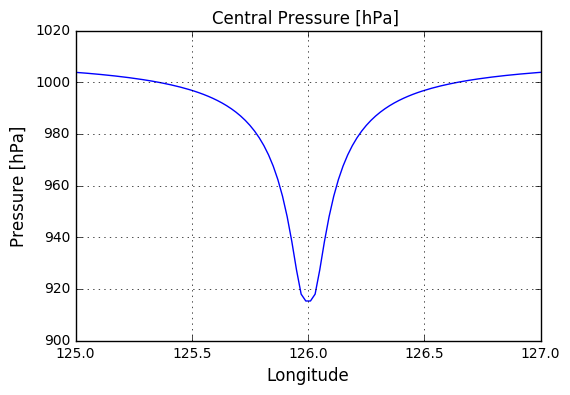

In [159]:
# Plot pressure
plt.figure(figsize=(6,4))
plt.plot(xcell[0,:],prcell[1500,:]/100)
plt.xlabel('Longitude',fontsize=12)
plt.ylabel('Pressure [hPa]',fontsize=12)
plt.title('Central Pressure [hPa] ')
plt.grid(True)
plt.xlim(xhc-1,xhc+1)
plt.show()

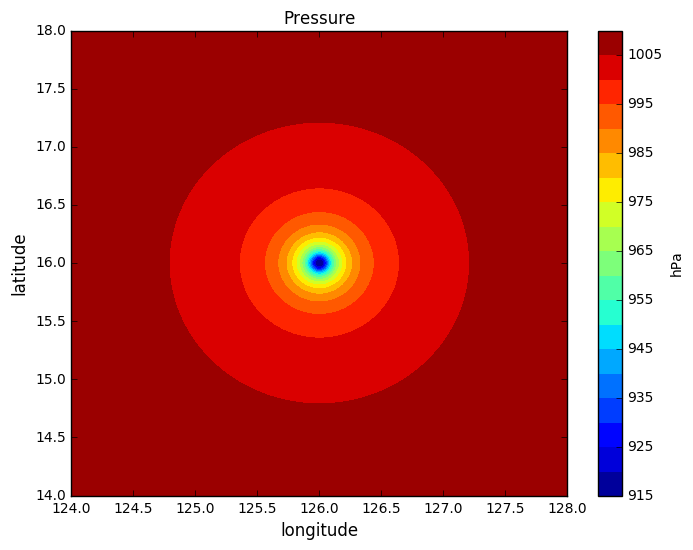

In [160]:
plt.figure(figsize=(8,6))
plt.contourf(xcell,ycell, prcell/100,20)
plt.xlabel('longitude',fontsize=12)
plt.ylabel('latitude',fontsize=12)
plt.title('Pressure',fontsize=12)
plt.colorbar(label='hPa')
plt.xlim(xhc-2,xhc+2)
plt.ylim(yhc-2,yhc+2)
plt.show()

##### Calculate wind

In [161]:
# calculate v (without vt)
vr=vel(rcell,b,rhoa,rmax,maxR,k,dp,x)

In [162]:
# calculate v (without vt)
vrcor=velcor(rcell,b,rhoa,rmax,maxR,k,dp,x,f)

In [163]:
# calculate v (with vt)
vx, vy, vxvt, vyvt = vel2(rcell,sinteta,costeta,b,rhoa,rmax,maxR,k,dp,x,vtx,vty)
v=np.sqrt(vx**2+vy**2)
vvt=np.sqrt(vxvt**2+vyvt**2)

In [164]:
# calculate v (with vt)
vxc, vyc, vxvtc, vyvtc = vel2cor(rcell,sinteta,costeta,b,rhoa,rmax,maxR,k,dp,x,vtx,vty,f)
vc=np.sqrt(vxc**2+vyc**2)
vvtc=np.sqrt(vxvtc**2+vyvtc**2)

In [165]:
# beta correction [with coriolis]+ vt
vg=vrcor

if yhc>0:
    vxb=-vg*(sinteta*cosb+costeta*sinb)
    vyb=vg*(costeta*cosb-sinteta*sinb)
else: 
    vxb=vg*(sinteta*cosb-costeta*sinb)
    vyb=-vg*(costeta*cosb+sinteta*sinb)


vxbvt=vxb+vtx*(1.-np.exp(-(rmax/rcell)**b)) 
vybvt=vyb+vty*(1.-np.exp(-(rmax/rcell)**b)) 
vbvt=np.sqrt(vxbvt**2+vybvt**2)

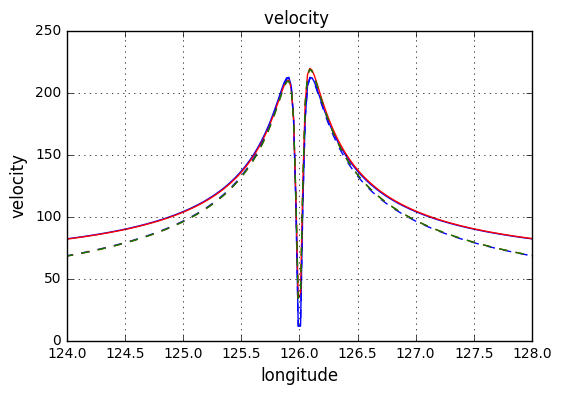

In [166]:
plt.figure(figsize=(6,4))
plt.plot(xcell[0,:],v[1500,:]*3.6)
plt.plot(xcell[0,:],vvt[1500,:]*3.6, '-r')
plt.plot(xcell[0,:],vc[1500,:]*3.6, '--b')
plt.plot(xcell[0,:],vvtc[1500,:]*3.6, '--r')
plt.plot(xcell[0,:],vbvt[1500,:]*3.6, '--g')
plt.xlabel('longitude',fontsize=12)
plt.ylabel('velocity',fontsize=12)
plt.title('velocity ')
plt.xlim((xhc-2,xhc+2))
plt.grid(True)
plt.show()

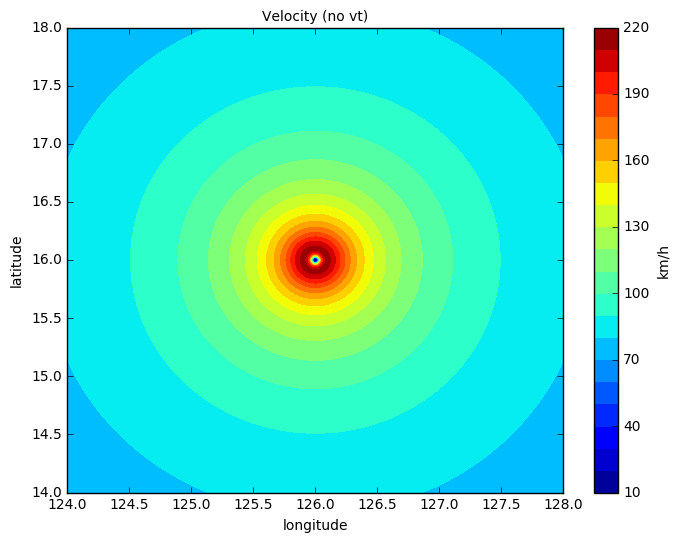

In [167]:
plt.figure(figsize=(8,6))
plt.contourf(xcell,ycell, v*3.6,20)
plt.xlabel('longitude',fontsize=10)
plt.ylabel('latitude',fontsize=10)
plt.title('Velocity (no vt)',fontsize=10)
plt.colorbar(label='km/h')
plt.xlim((xhc-2,xhc+2))
plt.ylim((yhc-2,yhc+2))
plt.show()

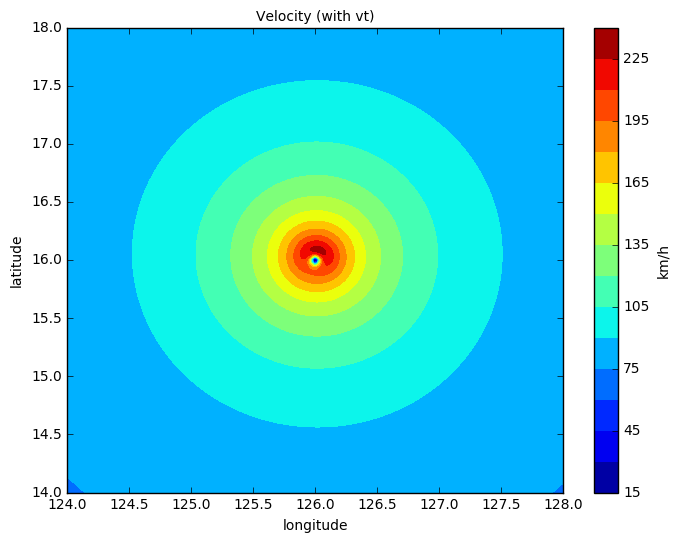

In [168]:
plt.figure(figsize=(8,6))
plt.contourf(xcell,ycell, vvt*3.6,20)
plt.xlabel('longitude',fontsize=10)
plt.ylabel('latitude',fontsize=10)
plt.title('Velocity (with vt)',fontsize=10)
plt.colorbar(label='km/h')
plt.xlim((xhc-2,xhc+2))
plt.ylim((yhc-2,yhc+2))
plt.show()

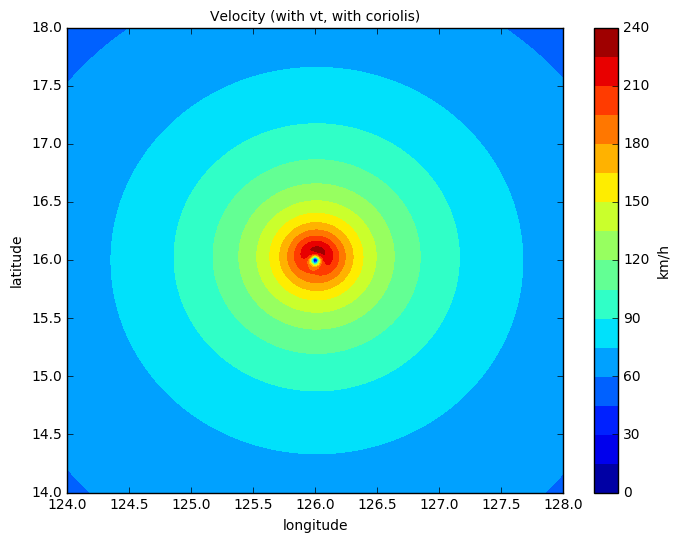

In [169]:
plt.figure(figsize=(8,6))
plt.contourf(xcell,ycell, vvtc*3.6,20)
plt.xlabel('longitude',fontsize=10)
plt.ylabel('latitude',fontsize=10)
plt.title('Velocity (with vt, with coriolis)',fontsize=10)
plt.colorbar(label='km/h')
plt.xlim((xhc-2,xhc+2))
plt.ylim((yhc-2,yhc+2))
plt.show()

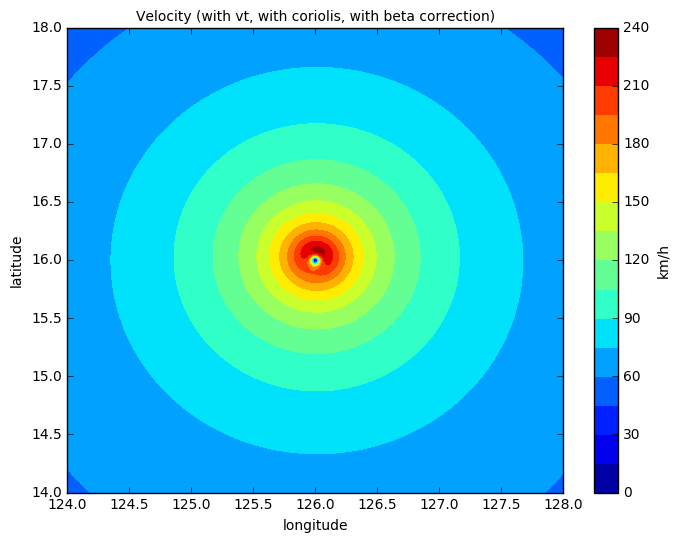

In [170]:
plt.figure(figsize=(8,6))
plt.contourf(xcell,ycell, vbvt*3.6,20)
plt.xlabel('longitude',fontsize=10)
plt.ylabel('latitude',fontsize=10)
plt.title('Velocity (with vt, with coriolis, with beta correction)',fontsize=10)
plt.colorbar(label='km/h')
plt.xlim((xhc-2,xhc+2))
plt.ylim((yhc-2,yhc+2))
plt.show()

In [171]:
from osgeo import gdal,gdal_array
import osr

dataTypeformat={1:np.byte,2:np.int32,3:np.int32,4:np.float32,5:np.float32,6:np.byte}
VSType={1:'VS_BOOLEAN',2:'VS_NOMINAL',3:'VS_ORDINAL',4:'VS_SCALAR',5:'VS_DIRECTION',6:'VS_LDD'}

def putmap(filename,var,geo,TYPE,nodata):
     driver=gdal.GetDriverByName('PCRaster')
     varw=var.astype(dataTypeformat[TYPE])
     gtype=gdal_array.NumericTypeCodeToGDALTypeCode(varw.dtype)
     NROWS,NCOLS = var.shape
     VS='PCRASTER_VALUESCALE={}'.format(VSType[TYPE])
     dst_ds=driver.Create(filename,NCOLS,NROWS,1,gtype,[VS])
     proj=osr.SpatialReference()
     proj.ImportFromEPSG(4326)
     dst_ds.SetProjection(proj.ExportToWkt())
     dst_ds.SetGeoTransform(geo)
     dst_ds.GetRasterBand(1).WriteArray(varw)
     dst_ds.GetRasterBand(1).SetNoDataValue(nodata)
     dst_ds.FlushCache()
     dst_ds=None
     return

In [172]:
#SAVEPATH='/mnt/pandora/Operations_Critech/Emergencies/2016/20160929_Caribbean_TC_MATTHEW/maps_7Oct/data/HWRF/'
SAVEPATH='/mnt/pandora/Users_Critech/Pamela/test/'

#SAVEPATH='tmp/'
print SAVEPATH

/mnt/pandora/Users_Critech/Pamela/test/


In [173]:
timei='00'

In [174]:
TYPE=4     
dd=xcell[0,1]-xcell[0,0]
print dd
geo=(xcell.min(),dd,0,ycell.max(),0, -dd)  
nodata=-9999.
putmap(SAVEPATH+'wind10m'+hurName+timei+'_'+str(bul)+'_'+'_nocoriolis.tif',np.flipud(vvt),geo,TYPE,nodata)
putmap(SAVEPATH+'wind10m'+hurName+timei+'_'+str(bul)+'_'+'_withcoriolis.tif',np.flipud(vvtc),geo,TYPE,nodata)
putmap(SAVEPATH+'wind10m'+hurName+timei+'_'+str(bul)+'_'+'_withcoriolis_withbeta.tif',np.flipud(vbvt),geo,TYPE,nodata)

0.02002002002
